### Calculating xT (action-based)
Calculate action based Expected Threat using the previously created possession chains.  This will leverage a prepared dataset, but the created dataframe in the prior section could have been leveraged for this scope.

### Opening the dataset
Open the data. It is the file created in the Possesion Chain segment, but saved and reloaded. The files are available on the github repository. There were prepared using the script from the previous section.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import os
import pathlib
import warnings
from joblib import load
from mplsoccer import Pitch

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.DataFrame()
for i in range(11):
    file_name = 'possession_chains_England' + str(i+1) + '.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'footy_analytics', 'data', file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index = True)
df = df.reset_index()

In [4]:
df.sample(3)

,level_0,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
164988,164988,42612,3,Throw in,[{'id': 1801}],340,"[{'y': 0, 'x': 19}, {'y': 6, 'x': 41}]",2499863,Free Kick,1623,...,42427,1623,0.000000,0,19.95,34.00,43.05,29.92,68.00,63.92
14977,14977,22289,8,Simple pass,[{'id': 1801}],64966,"[{'y': 6, 'x': 82}, {'y': 7, 'x': 80}]",2499732,Pass,1651,...,3900,1651,0.009225,1,86.10,29.92,84.00,29.24,63.92,63.24
206343,206343,3766,8,Simple pass,[{'id': 1801}],8514,"[{'y': 55, 'x': 11}, {'y': 27, 'x': 71}]",2499899,Pass,1612,...,53146,1612,0.000000,0,11.55,3.40,74.55,15.64,30.60,49.64


### Preparing variables for models
The models will use all non-linear combinations of the starting and ending x coordinate and c (distance from the middle of the pitch). Create combinations with replacement of these variables - to get their non-linear transfomations. In the next step, multiply the columns in the combination and create a model with the output.

In [5]:
def create_model_combo_cols(df=df):
    '''Create column combinations from x0,x1, c0, and c1
     ---
     x0 = starting x position
     x1 = finishing x position on field
     c0 = starting distance from center of field
     c1 = finishing distance from center of field
    '''
    var = ["x0", "x1", "c0", "c1"] # column name placeholders
    inputs = []

    for v in range(1,4):
        inputs.extend(combinations_with_replacement(var, v))
    
    for i in inputs:
        if len(i) > 1:
            column = ''
            x = 1
            for c in i:
                column += c
                x = x*df[c]
            df[column] = x
            var.append(column)
    return var,inputs

In [6]:
v,i = create_model_combo_cols(df)

In [7]:
# investigate original and created column combinations
df[v[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,8.804096,246.514688,6902.411264
1,6162.867200,5502.560000,4913.000000
2,4126.920000,3466.612800,2911.954752


### Calculating action-based Expected Threat values for passes
To predict the outcome of a shot requires training a model (XGB classifier) on the Bundesliga dataset. In the code, the model is saved in the file. It was trained using the xgboost library version 1.6.2. Training steps are provided, but commented out. 

Using it allows predicting the probability of a chain ending with a shot. Then, on chains ending with a shot, fit a linear regression to calculate the probability that a shot ended with a goal. Product of these 2 values is the action-based Expected Threat statistic.
1. Use XGBoost Classifier to predict the likelihood of a shoot
2. Linear regression to predict the likelihood of a goal
3. Multiply them (p_shot x p_goal) to yield action-based expected Threat

In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from xgboost import XGBClassifier

---
#### Classifier
Test Classifier, but will not work for probability of pass position to lead to a shot.

In [9]:
## TRAINING, it's not perfect ML procedure, but results in AUC 0.2 higher than Logistic Regression ###

passes = df.loc[ df["eventName"].isin(["Pass"])] # filter for passes
X = passes[v].values
y = passes["shot_end"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
xgb = XGBClassifier(n_estimators = 100, max_depth=4, random_state=123)

In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 5, n_jobs = -1)
print(np.mean(scores), np.std(scores))
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
y_pred = xgb.predict(X_test)
print(xgb.score(X_test, y_test))

0.9204402601155547 7.145374560398199e-05
0.9208466420305432
0.92032403609516


In [14]:
# 33 goals doesn't look to good.  Also, cannot use a classifier since looking for probability of shot. 
# this is why the regressor was used.
pd.Series(y_pred).value_counts() 

0    29223
1       33
Name: count, dtype: int64

---
#### Regressor
Ran original code again with regressor to return a probability of a shot, not a binary goal/no goal prediction.

#### Model application
Reload data into the train test groupings and run the model to predict if the passing sequence ended in a shot. At this point, there is no need to validate the model which was done previously.  The only objective is a prediction since this represents the likelihood for a shot, and not if one actually occurred.

In [15]:
## TRAINING, it's not perfect ML procedure, but results in AUC 0.2 higher than Logistic Regression ###

passes = df.loc[ df["eventName"].isin(["Pass"])] # filter for passes
X = passes[v].values
y = passes["shot_end"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
xgb = XGBRegressor(n_estimators = 100, max_depth=4, random_state=123)

In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 5, n_jobs = -1)
print(np.mean(scores), np.std(scores))
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
y_pred = xgb.predict(X_test)
print(xgb.score(X_test, y_test))

0.05554421091219741 0.003169110911737059
0.08722348145784209
0.05908842951658555


In [20]:
y_pred # probability of a shot, which is a decimal base, but x 100 to get a percentage

array([0.04468377, 0.04183801, 0.03390996, ..., 0.01558963, 0.03831318,
       0.015978  ], dtype=float32)

### Apply the model
Using the regressor model, a prediction column is added indicating the likelihood of a shot.  The y_pred values are all low percentages, which aligns with some of the analysis conducted previously around xG and xT.  These are not high percentages in general. 

Tried to save and reload model unsuccessfully.  The original soccermatics work was conducted in an older version of XGBoost, and the new model loading is not compatible.  Used above created model in place of the loaded model.  Outcomes may be different for the predictions.

In [25]:
from xgboost import Booster

In [34]:
# predict if ended with shot
passes = df.loc[df["eventName"].isin(["Pass"])]
X = passes[v].values
y = passes["shot_end"].values
# load saved model from git hub
# path_model = os.path.join(str(pathlib.Path().resolve().parents[0]), 'footy_analytics', 'data', 'finalized_model.sav')
# model = load(path_model)
# Booster.save_model(xgb, 'finalized_model1.sav')
# model = Booster.load_model('finalized_model1.sav')
# predict probability of pass position resulting in a shot end
y_pred_proba = xgb.predict(X)


In [35]:
y_pred_proba

array([0.04009402, 0.04183381, 0.04691054, ..., 0.05473039, 0.02997477,
       0.02710184], dtype=float32)

In [37]:
passes["shot_prob"] = y_pred_proba
# OLS linear regression predicting xG for the shooting positions taken (shot_end ==1)
shot_ended = passes.loc[passes["shot_end"] == 1]
X2 = shot_ended[v].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)
y_pred = lr.predict(X)
passes["xG_pred"] = y_pred
# calculate xGchain
passes["xT"] = passes["xG_pred"]*passes["shot_prob"]

passes[["xG_pred", "shot_prob", "xT"]].head(5)

,xG_pred,shot_prob,xT
0,0.121099,0.040094,0.004855
1,0.108244,0.041834,0.004528
2,0.121571,0.046911,0.005703
3,0.118808,0.035048,0.004164
4,0.116028,0.041501,0.004815


### Making a plot of pass predicted/projected xT values
Now plot the pass as before, but incorporate the predicted xT value determined from the modeling above. This is the same plot seen in previous section but this time the value is assigned to passes and line width is proportional to its value.

In [38]:
chain = df.loc[df["possesion_chain"] == 4]
# get passes
passes_in = passes.loc[df["possesion_chain"] == 4]
max_value = passes_in["xT"].max()
# get events different than pass
not_pass = chain.loc[chain["eventName"] != "Pass"].iloc[:-1]
# final row or event is assigned to shot as the last event of the chain.  
shot = chain.iloc[-1]

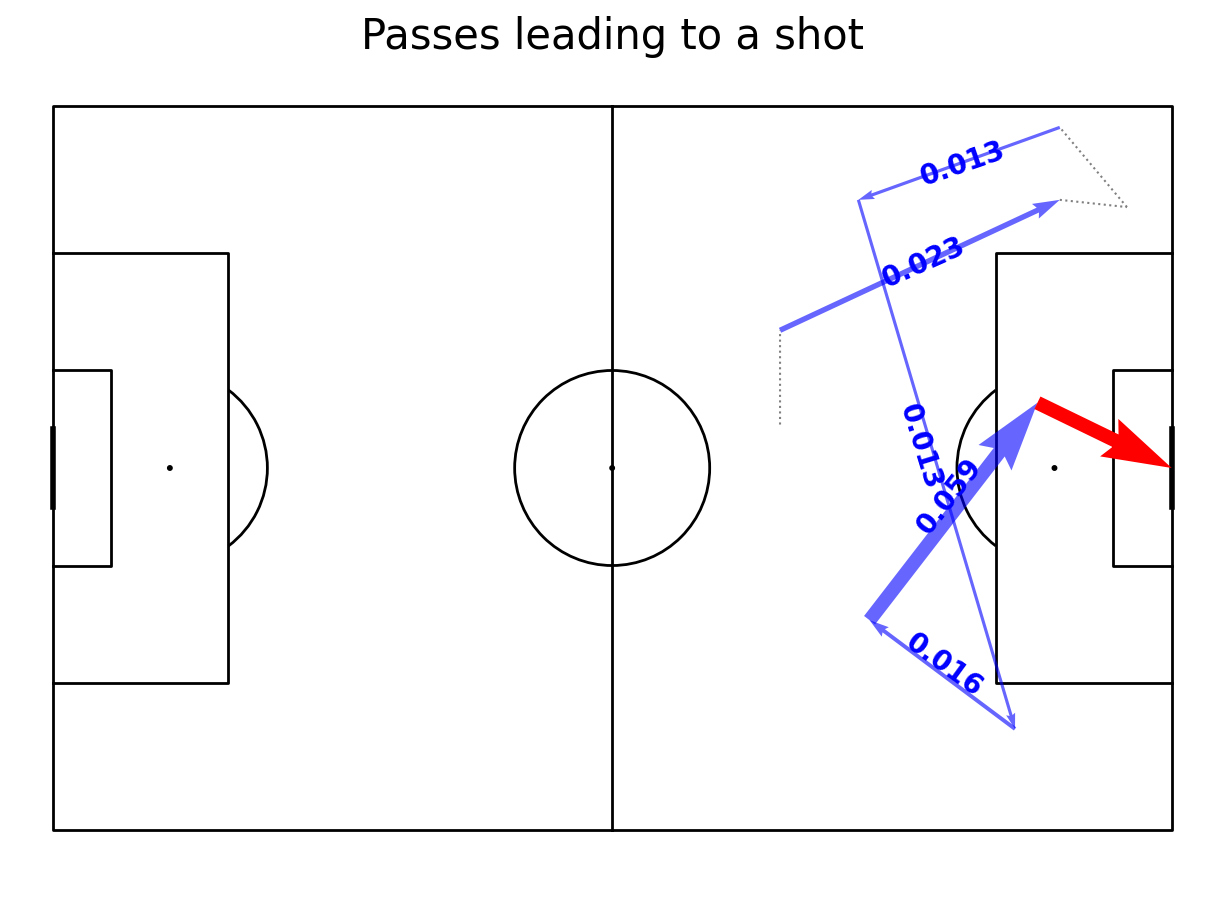

In [39]:
# plot pitch canvas
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# add size adjusted arrows
for i, row in passes_in.iterrows():
    value = row["xT"]
    line_width = (value / max_value * 10) # adjust the line width so that the more passes, the wider the line
    angle = np.arctan((row.y1-row.y0)/(row.x1-row.x0))*180/np.pi # get angle
    pitch.arrows(row.x0, row.y0, row.x1, row.y1,  
                 alpha=0.6, width=line_width, zorder=2, 
                 color="blue", ax = ax["pitch"])            # plot lines on the pitch
    ax["pitch"].text((row.x0+row.x1-8)/2, (row.y0+row.y1-4)/2, str(value)[:5], 
                     fontweight = "bold", color = "blue", zorder = 4, 
                     fontsize = 20, rotation = int(angle))  #annotate text

# shot
pitch.arrows(shot.x0, shot.y0,shot.x1, shot.y1, width=line_width, 
             color = "red", ax=ax['pitch'], zorder =  3)

# other passes like arrows
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, 
            color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])


ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()